In [1]:
import numpy as np
import cv2
import struct
import math
import time
import os
import math
import time
import sys
import PIL
from models import *
import torchvision.transforms as transforms
from torch.autograd import Variable
#from models import *
import torch.nn as nn
import torch.nn.functional as F
import torch
from ssd import build_ssd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import scipy.misc
import random
import sys

from torchvision import models
from torchvision.models.vgg import VGG

In [2]:
n_class = 4
width = 640
height = 480
cuda = True if torch.cuda.is_available() else False
prob_threshold = 0.3
border = 0
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
data_transform = transforms.Compose([transforms.Resize((256, 256), PIL.Image.BICUBIC),
                transforms.ToTensor()])
net = build_ssd('test', 300, 4)    # initialize SSD
net.load_weights('/media/arg_ws3/5E703E3A703E18EB/ssd300_subt_280000.pth')
if cuda:
    net = net.cuda()

/home/arg_ws3/gan_rv/catkin_ws/src/classify/src/ssd.py:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.priors = Variable(self.priorbox.forward(), volatile=True)
/home/arg_ws3/gan_rv/catkin_ws/src/classify/src/layers/modules/l2norm.py:17: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(self.weight,self.gamma)


Loading weights into state dict...
Finished!


In [3]:
##############################
#           U-NET
##############################

class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [  nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
                    nn.InstanceNorm2d(out_size),
                    nn.ReLU(inplace=True)]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x

class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)


        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh()
        )


    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)

In [28]:
means = np.array([103.939, 116.779, 123.68]) / 255. # mean of three channels in the order of BGR
h, w  = 256, 256
fcn_class = 4
model_dir = "/media/arg_ws3/5E703E3A703E18EB/research/subt_fcn/models/fcn_crop_unet"   # 
#model_name = "FCNs_batch12_epoch32_RMSprop_lr0.0001.pkl"
model_name = "FCNs_batch12_epoch20_RMSprop_lr0.0001.pkl"
#vgg_model = VGGNet(cfg, requires_grad=True, remove_fc=True)
#fcn_model = FCN16s(pretrained_net=vgg_model, n_class=fcn_class)

use_gpu = torch.cuda.is_available()
num_gpu = list(range(torch.cuda.device_count()))

'''if use_gpu:
    ts = time.time()
    vgg_model = vgg_model.cuda()
    fcn_model = fcn_model.cuda()
    fcn_model = nn.DataParallel(fcn_model, device_ids=num_gpu)
    print("Finish cuda loading, time elapsed {}".format(time.time() - ts))
state_dict = torch.load(os.path.join(model_dir, model_name))
fcn_model.load_state_dict(state_dict)'''

use_gpu = torch.cuda.is_available()
num_gpu = list(range(torch.cuda.device_count()))

#vgg_model = VGGNet(requires_grad=True, remove_fc=True)
#fcn_model = FCN16s(pretrained_net=vgg_model, n_class=n_class)
fcn_model = GeneratorUNet(in_channels=3, out_channels=fcn_class)
state_dict = torch.load(os.path.join(model_dir, model_name))
fcn_model.load_state_dict(state_dict)
#use_gpu = False
if use_gpu:
    ts = time.time()
    #vgg_model = vgg_model.cuda()
    fcn_model = fcn_model.cuda()
    #fcn_model = nn.DataParallel(fcn_model, device_ids=num_gpu)
    print("Finish cuda loading, time elapsed {}".format(time.time() - ts))

mask1 = np.zeros((h, w))
MAXAREA = 18000
MINAREA = 1000

Finish cuda loading, time elapsed 0.04046034812927246


In [29]:
means     = np.array([103.939, 116.779, 123.68]) / 255. # mean of three channels in the order of BGR
h, w      = 256, 256
val_h     = h
val_w     = w

In [30]:
def show_img(img, pred):
    fig=plt.figure(figsize=(20, 20))
    fig.add_subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    fig.add_subplot(1,2,2)
    plt.imshow(pred)
    plt.show()

In [31]:
cv_image = cv2.imread("/media/arg_ws3/5E703E3A703E18EB/data/subt_tunnel_hsinchu/bag3/Images/users/andyser/subt_real/evl_data/bag3/10.jpg")

In [32]:
def fcn_predict(img_):
    img_shape = img_.shape
    img_ = cv2.resize(img_, (256, 256), interpolation=cv2.INTER_CUBIC)
    img = img_[:, :, ::-1]  # switch to BGR
        
    img = np.transpose(img, (2, 0, 1)) / 255.
    img[0] -= means[0]
    img[1] -= means[1]
    img[2] -= means[2]

    # convert to tensor
    img = torch.from_numpy(img.copy()).float()
    img = img.unsqueeze(0)
    #print(img)
    
    output = fcn_model(img.cuda())
    output = output.data.cpu().numpy()

    N, _, h, w = output.shape
    pred = output.transpose(0, 2, 3, 1).reshape(-1, fcn_class).argmax(axis = 1).reshape(N, h, w)
    #print(pred.shape, N)
    pred_img = np.zeros((pred[0].shape[0], pred[0].shape[1]), np.uint8)
    for i in range(pred[0].shape[0]):
        for j in range(pred[0].shape[1]):
            if pred[0][i][j] == 1: #extinguisher
                pred_img[i][j] = 1
            elif pred[0][i][j] == 2: #drill
                pred_img[i][j] = 3
            elif pred[0][i][j] == 3: #backpack
                pred_img[i][j] = 2
    pred_img = cv2.resize(pred_img, (img_shape[1], img_shape[0]), interpolation=cv2.INTER_CUBIC)
    return pred_img

- predict: please use "tanh" activation function

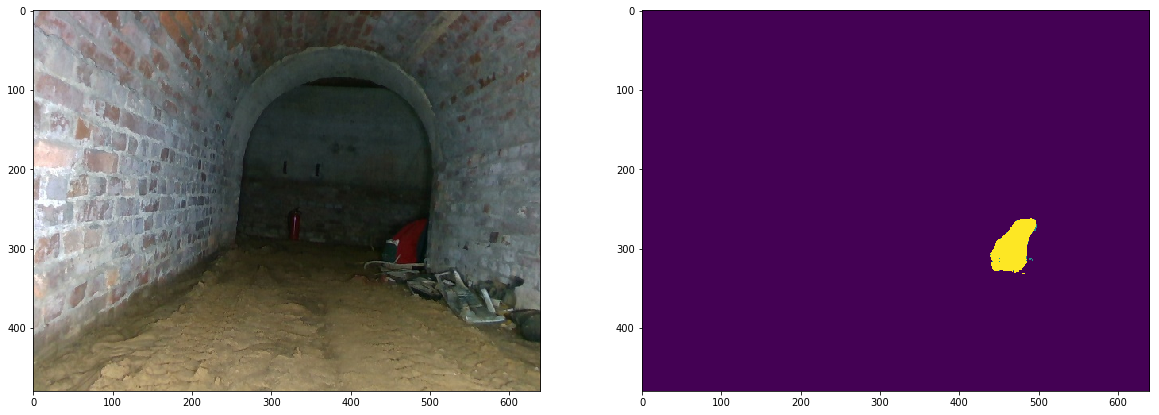

In [33]:
def predict(image):
    h, w = image.shape[:2]
    tmp_img = image.copy()
    generate_img = np.zeros(image.shape, np.uint8)
    # generate_img = image.copy()
    img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    x = cv2.resize(img, (300, 300)).astype(np.float32)
    x -= (104.0, 117.0, 123.0)
    x = x.astype(np.float32)
    x = x[:, :, ::-1].copy()
    x = torch.from_numpy(x).permute(2, 0, 1)

    #SSD Forward Pass
    xx = Variable(x.unsqueeze(0))     # wrap tensor in Variable
    if torch.cuda.is_available():
        xx = xx.cuda()
    y = net(xx)
    # print(1./(t2-t1))
    scale = torch.Tensor(image.shape[1::-1]).repeat(2)
    detections = y.data	# torch.Size([1, 4, 200, 5]) --> [batch?, class, object, coordinates]
    objs = []
    for i in range(detections.size(1)): # detections.size(1) --> class size
        for j in range(5):	# each class choose top 5 predictions
            if detections[0, i, j, 0].numpy() > prob_threshold:
                score = detections[0, i, j, 0]
                pt = (detections[0, i, j,1:]*scale).cpu().numpy()
                objs.append([pt[0], pt[1], pt[2]-pt[0]+1, pt[3]-pt[1]+1, i])
    for obj in objs:
        region = [int(obj[1] - border), int(obj[1] + obj[3] + border),\
                  int(obj[0] - border), int(obj[0] + obj[2] + border)]

        bbx_img = image[region[0] : region[1], region[2]: region[3]]
        if bbx_img.shape[0] == 0 or bbx_img.shape[1]==0:
            continue
        mask = fcn_predict(bbx_img)
        # lis = []
        # for i in range(mask.shape[0]):
        # 	for j in range(mask.shape[1]):
        # 		if mask[i][j] not in lis:
        # 			lis.append(mask[i][j])
        # print(lis)
        #print(mask.transpose(2,0,1).shape)
        #output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis = 1).reshape(N, h, w)
        #mask = mask.transpose(2, 0, 1).reshape(-1, 2).argmax(axis = 1).reshape(256, 256, 1)
        mask = cv2.resize(mask, (region[3]-region[2], region[1]-region[0]))
        
        # add class label to mask
        '''if obj[4] == 1: #extinguisher
            label = 1
        elif obj[4] == 2: #drill
            label = 3
        elif obj[4] == 3: #backpack
            label = 2
        mask[mask!=0]=label'''
        #ret, mask = cv2.threshold(mask, 100, label, cv2.THRESH_BINARY) # pixel value only belongs to 0 or 255
        
        if generate_img[region[0] : region[1], region[2]: region[3]].shape[:2] == mask.shape:
            generate_img[region[0] : region[1], region[2]: region[3]] = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    
    generate_img = generate_img[:,:,0]
    return generate_img
generate_img = predict(cv_image)
show_img(cv_image, generate_img)

- predict_2ch: please use "sigmoid" activation function

In [34]:
#im = np.ones((480, 640, 3))*100
im = np.zeros((480, 640, 3))
for i in range(generate_img.shape[0]):
    for j in range(generate_img.shape[1]):
        if generate_img[i][j] == 1:
            im[i][j][0] = 255
        elif generate_img[i][j] == 2:
            im[i][j][1] = 255
        elif generate_img[i][j] == 3:
            im[i][j][2] = 255
cv2.imwrite("pred_gan.jpg", im)
cv2.imwrite("orig_gan.jpg", cv_image)

True

extinguisher: 1

drill: 3

backpack: 2

In [35]:
def analysis(pred, target, h, w):
    # TP, FN, FP, TN
    TP = np.zeros(n_class, dtype = np.float128)
    FN = np.zeros(n_class, dtype = np.float128)
    FP = np.zeros(n_class, dtype = np.float128)

    target = target.reshape(h * w)
    pred = pred.reshape(h * w)
    
    con_matrix = confusion_matrix(target, pred,labels = np.arange(0,n_class,1))
    con_matrix[0][0] = 0
    for i in range(0, n_class):
        for j in range(0, n_class):
            if i == j:
                TP[i] += con_matrix[i][j]
            if i != j:
                FP[j] += con_matrix[i][j]
                FN[i] += con_matrix[i][j]
    return TP, FN, FP
                
def pixel_acc(pred, target):
    correct = (pred == target).sum()
    total   = (target == target).sum()
    return correct / total

- Use predict(input_img) for 1 channel output version
- Use predict_2ch(input_img) for 2 channel output version

In [36]:
def val(data_dir, score_dir, name, val_txt):
    #score_dir = "/media/arg_ws3/5E703E3A703E18EB/research/subt_fcn/scores/gan_ssd_622"
    if not os.path.exists(score_dir):
        os.makedirs(score_dir)
    TP = np.zeros(n_class-1, dtype = np.float128)
    FN = np.zeros(n_class-1, dtype = np.float128)
    FP = np.zeros(n_class-1, dtype = np.float128)
    total_ious = []
    pixel_accs = []
    data_list = []
    
    csv_data = pd.read_csv(val_txt)
    for idx in range(len(csv_data)):
        img_name = csv_data.iloc[idx, 0]
        label_name = csv_data.iloc[idx, 1]
        input_img = cv2.imread(os.path.join(data_dir, img_name),cv2.IMREAD_UNCHANGED)
        target = cv2.imread(os.path.join(data_dir, label_name), cv2.IMREAD_GRAYSCALE)
        
        # Change your prediction here
        pred = predict(input_img)

        h, w = pred.shape

        pixel_accs.append(pixel_acc(pred, target))
        _TP, _FN, _FP =  analysis(pred, target, h, w)
        TP += _TP[1:n_class]
        FN += _FN[1:n_class]
        FP += _FP[1:n_class]
            
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    ious = TP / (TP + FN + FP)
    fscore = 2*TP / (2*TP + FN + FP)
    total_ious = np.array(total_ious).T  # n_class * val_len
    pixel_accs = np.array(pixel_accs).mean()
    
    print("name: {}, pix_acc: {}, meanIoU: {}, IoUs: {}, recall: {}, precision: {}, fscore: {}"\
          .format(name, pixel_accs, np.nanmean(ious), ious, recall, precision, fscore))
    
    f1 = open(score_dir + "/cls_acc_log.txt","a+")
    f1.write('name:'+ str(name) + ', pix_acc: ' + str(pixel_accs) + '\n' )
    f2 = open(score_dir + "/cls_iou_log.txt","a+")
    f2.write('name:'+ str(name) + ', class ious: ' + str(ious) + '\n' )
    f3 = open(score_dir + "/mean_iou_log.txt","a+")
    f3.write('name:'+ str(name) + ', mean IoU: ' + str(np.nanmean(ious)) + '\n' ) 
    f4 = open(score_dir + "/recall_log.txt","a+")
    f4.write('name:'+ str(name) + ', class recall: ' + str(recall) + '\n' )
    f5 = open(score_dir + "/precision_log.txt","a+")
    f5.write('name:'+ str(name) + ', class precision: ' + str(precision) + '\n' )    
    f6 = open(score_dir + "/fscore_log.txt","a+")
    f6.write('name:'+ str(name) + ', class fscore: ' + str(fscore) + '\n' )
    f7 = open(score_dir + "/mean_fscore_log.txt","a+")
    f7.write('name:'+ str(name) + ', mean fscore: ' + str(np.nanmean(fscore)) + '\n' )
    f8 = open(score_dir + "/mean_precision_log.txt","a+")
    f8.write('name:'+ str(name) + ', mean precision: ' + str(np.nanmean(precision)) + '\n' ) 
    f9 = open(score_dir + "/mean_recall_log.txt","a+")
    f9.write('name:'+ str(name) + ', mean recall: ' + str(np.nanmean(recall)) + '\n' ) 

In [37]:
data_dir = '/media/arg_ws3/5E703E3A703E18EB/data/subt_tunnel_hsinchu/'
val_txt = '/media/arg_ws3/5E703E3A703E18EB/data/subt_tunnel_hsinchu/test.csv'
score_dir = "/media/arg_ws3/5E703E3A703E18EB/research/subt_fcn/scores/fcn_crop_unet_18mnt"
name = 'fcn_crop_unet_18mnt_epoch8'

In [38]:
val(data_dir, score_dir, name, val_txt)

name: fcn_crop_unet_18mnt_epoch8, pix_acc: 0.9967717943948413, meanIoU: 0.6863735679439404, IoUs: [0.7007703  0.68292457 0.67542584], recall: [0.83832939 0.73385924 0.90084992], precision: [0.8102726  0.90774462 0.72966889], fscore: [0.82406225 0.81159261 0.80627363]
